In [1]:
# Set seeds
from numpy.random import seed
import tensorflow as tf
seed(42)
tf.random.set_seed(42)

In [2]:
!pip install imbalanced-learn --upgrade

     |████████████████████████████████| 215kB 7.4MB/s 
     |████████████████████████████████| 22.3MB 1.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [3]:
# Upgrade module imbalanced-learn if ran on Google Colab
#!pip install imbalanced-learn --upgrade

# Import modules
import imblearn
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sklearn

from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from keras.applications.resnet import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from numpy import expand_dims
from platform import python_version
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.utils import plot_model

%matplotlib inline

# Versions
print("Version Python:",python_version())
print()
print("Version Imblearn:",imblearn.__version__)
print("Version Keras:",keras.__version__)
print("Version Matplotlib:",'3.8.3')
print("Version NumPy:",np.__version__)
print("Version Pandas:",pd.__version__)
print("Version Scikit-learn:",sklearn.__version__)
print("Version TensorFlow:",tf.__version__)

Version Python: 3.7.10

Version Imblearn: 0.8.0
Version Keras: 2.5.0
Version Matplotlib: 3.8.3
Version NumPy: 1.19.5
Version Pandas: 1.1.5
Version Scikit-learn: 0.24.2
Version TensorFlow: 2.5.0


In [4]:
# Set data folder
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/'
data = pd.read_pickle(os.path.join(data_folder, 'data.pkl'))

Mounted at /content/drive


In [5]:
# Encode the relevant features for the metadata model
labelencoder_sex = LabelEncoder()
data['sex'] = labelencoder_sex.fit_transform(data['sex'])
data['age'] = minmax_scale(data['age'])
dummies = pd.get_dummies(data.localization)
data = pd.concat([data, dummies], axis=1)

In [6]:
# Create training, validation amd test sets (Derived from: https://www.kaggle.com/kaimingk/skin-cancer-mnist-ham10000)

# Split 70%, 10%, 20%. Test and validation, together 30%, should be from unique ID's only
size_val_test = 0.3 * len(data)
val_test_ratio_from_unique = size_val_test/len(data[data.unique == True])

# Training data = remainder of unique ID's + non-uniques. Split is stratified by lesion type (benign/malignant)
mb_data_train_unique, mb_data_val_test = train_test_split(data[data["unique"] == True], test_size = val_test_ratio_from_unique, stratify=data[data["unique"] == True]["lesion_type_cat"], random_state = 42)
mb_data_train = pd.concat((mb_data_train_unique, data[data["unique"] == False]), axis = 0)

# Split validation and test sets. Split is stratified by lesion type (benign/malignant)
mb_data_validation, mb_data_test = train_test_split(mb_data_val_test, test_size = 0.6667, stratify=mb_data_val_test["lesion_type_cat"], random_state = 42)

# Class balancing (random oversampling)
X = mb_data_train.drop(['lesion_type_cat'], axis=1)
y = mb_data_train['lesion_type_cat']

X_test = mb_data_test.drop(['lesion_type_cat'], axis=1)
y_test = mb_data_test['lesion_type_cat']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

ros = RandomOverSampler(random_state=42)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

mb_data_train = pd.concat([X_resampled, y_resampled], axis=1)
mb_data_test = pd.concat([X_test_resampled, y_test_resampled], axis=1)

In [8]:
# Create variables for feature (x) training, validation and test sets for the ResNet model
mb_data_train_x = np.asarray(mb_data_train['image'].tolist())
mb_data_validation_x = np.asarray(mb_data_validation['image'].tolist())
mb_data_test_x = np.asarray(mb_data_test['image'].tolist())

# Create variables for feature (x) training, validation and test sets for the ANN model
mb_data_train_meta = mb_data_train.iloc[:, [8,11,18,19,20,21,22,23,24,25,26,27,28,29,30,31]]
mb_data_validation_meta = mb_data_validation.iloc[:, [9,12,19,20,21,22,23,24,25,26,27,28,29,30,31,32]]
mb_data_test_meta = mb_data_test.iloc[:, [8,11,18,19,20,21,22,23,24,25,26,27,28,29,30,31]]

# Create variables for target (y) 
mb_data_train_y = np.asarray(mb_data_train['lesion_type_cat'].tolist())
mb_data_validation_y = np.asarray(mb_data_validation['lesion_type_cat'].tolist())
mb_data_test_y = np.asarray(mb_data_test['lesion_type_cat'].tolist())

# One-hot encoding of target variable
mb_num_classes = len(np.sort(data['lesion_type_cat'].unique()))

mb_data_train_y = to_categorical(mb_data_train_y, num_classes = mb_num_classes)
mb_data_validation_y = to_categorical(mb_data_validation_y, num_classes = mb_num_classes)
mb_data_test_y = to_categorical(mb_data_test_y, num_classes = mb_num_classes)

In [10]:
# Setting data augmentation parameters 
data_augmentation = ImageDataGenerator(
    rotation_range = 60,
    zoom_range = 0.2,  
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,  
    vertical_flip = True,  
    shear_range = 10) 

In [11]:
# Fit data augmentation to images
data_augmentation.fit(mb_data_train_x)

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 100, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 3, 4, 2048)   23587712    input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            136         input_3[0][0]                    
_____________________________

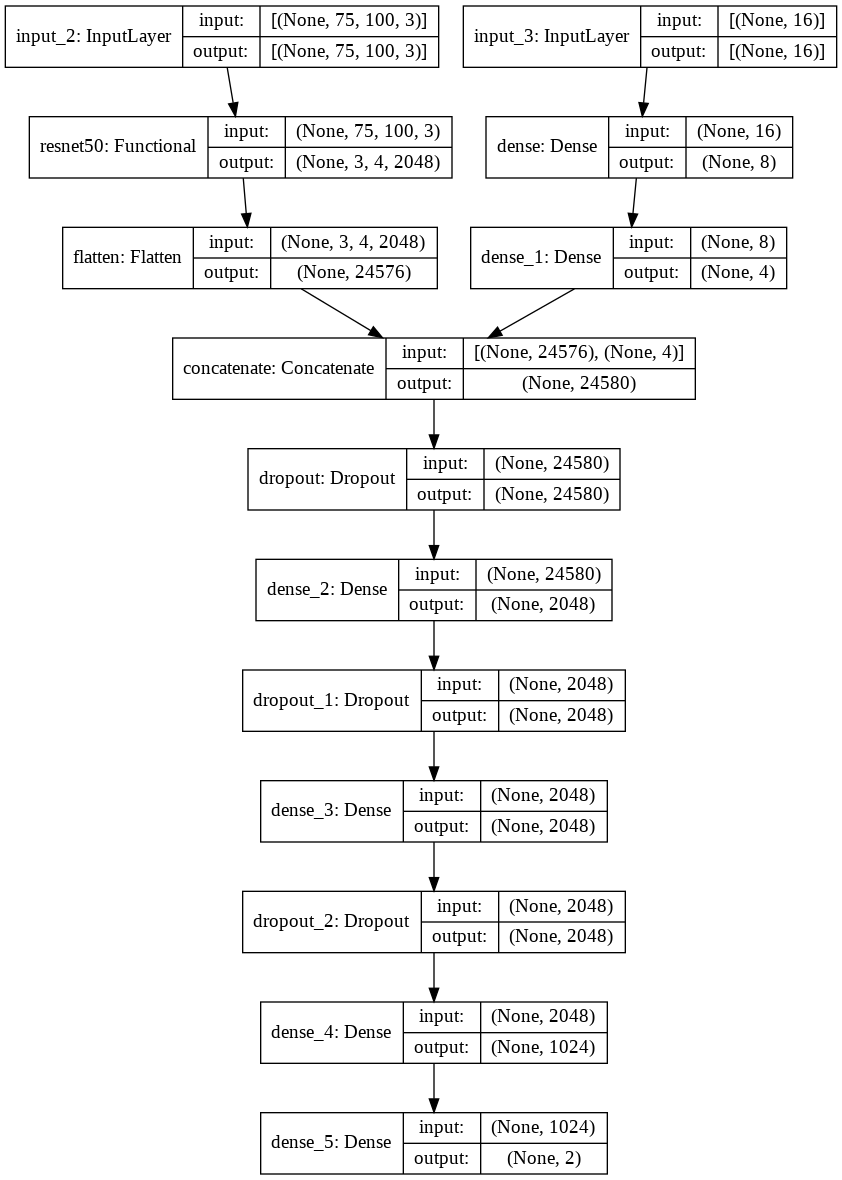

In [12]:
# Model parameters
input_shape_resnet = (75, 100, 3)
input_shape_meta = mb_data_train_meta.shape[1]

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 50
batch_size = 32

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')
history = History()

# Create ResNet
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape_resnet)
inp1 = Input(input_shape_resnet)
x1 = resnet (inp1)
x1 = Flatten() (x1)

# Create metadata ANN 
inp2 = Input(input_shape_meta)
x2 = Dense(8, activation="relu")(inp2)
x2 = Dense(4, activation="relu")(x2)
#x2 = Flatten() (x2)

# Merge ResNet and ANN
merge = concatenate([x1, x2])
merge = Dropout(0.2)(merge)
merge = Dense(2048, activation="relu") (merge)
merge = Dropout(0.2)(merge)
merge = Dense(2048, activation="relu") (merge)
merge = Dropout(0.2)(merge)
merge = Dense(1024, activation="relu") (merge)
output = Dense(2, activation='sigmoid')(merge)

# Create final model
Multimodal_binary = Model(inputs=[inp1, inp2], outputs=output)

# Layers in ResNet are pretrained (ImageNet)
resnet.trainable = False

# Compile model  
Multimodal_binary.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy'])
plot_model(Multimodal_binary, to_file='multiple_inputs.png', show_shapes = True)

# Output model architecture
print(Multimodal_binary.summary())
plot_model(Multimodal_binary, to_file=os.path.join(data_folder, 'multimodal_architecture.png'),show_shapes = True)

In [13]:
# Fit and save model 
mb_history = Multimodal_binary.fit(
                        data_augmentation.flow(x=[mb_data_train_x,mb_data_train_meta],y=mb_data_train_y, 
                        batch_size=batch_size),
                        epochs = epochs, 
                        validation_data = ([mb_data_validation_x,mb_data_validation_meta],mb_data_validation_y),
                        verbose = 1, 
                        steps_per_epoch=mb_data_train_x.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor, history])

Multimodal_binary.save(os.path.join(data_folder,"Multimodal_binary_model"))





Epoch 1/50
324/324 [==============================] - 82s 93ms/step - loss: 1.5212 - accuracy: 0.6713 - val_loss: 0.2077 - val_accuracy: 0.9006
Epoch 2/50
324/324 [==============================] - 25s 78ms/step - loss: 0.5138 - accuracy: 0.7452 - val_loss: 0.1998 - val_accuracy: 0.8904
Epoch 3/50
324/324 [==============================] - 25s 78ms/step - loss: 0.4776 - accuracy: 0.7619 - val_loss: 0.1832 - val_accuracy: 0.8883
Epoch 4/50
324/324 [==============================] - 25s 79ms/step - loss: 0.4835 - accuracy: 0.7596 - val_loss: 0.1747 - val_accuracy: 0.9109
Epoch 5/50
324/324 [==============================] - 25s 78ms/step - loss: 0.4713 - accuracy: 0.7622 - val_loss: 0.1785 - val_accuracy: 0.9006
Epoch 6/50
324/324 [==============================] - 26s 80ms/step - loss: 0.4625 - accuracy: 0.7698 - val_loss: 0.1485 - val_accuracy: 0.9344
Epoch 7/50
324/324 [==============================] - 25s 79ms/step - loss: 0.4558 - accuracy: 0.7788 - val_loss: 0.1746 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Multimodal_binary_model/assets


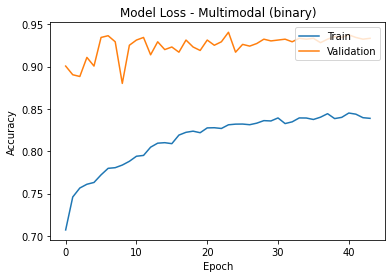

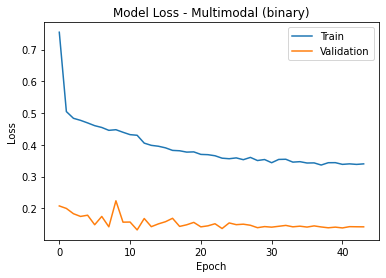

In [14]:
# Accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss - Multimodal (binary)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Accuracy - Multimodal (binary).png')
plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

# Loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - Multimodal (binary)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Loss - Multimodal (binary).png')
plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

In [15]:
with open(os.path.join(data_folder, 'data_mb.pkl'), 'wb') as f:
    pickle.dump([mb_data_train_x,mb_data_validation_x,mb_data_train_meta,mb_data_validation_meta,mb_data_test_x,mb_data_test_meta,mb_data_train_y,mb_data_validation_y,mb_data_test_y], f)